## Notebook to develop supervised classification algorithm for identifying snow in PlanetScope 4-band imagery
Rainey Aberle

Adapted from the [SciKit Learn Classifier comparison tutorial](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

### Initial setup

In [1]:
# -----Import packages
import os
import glob
import numpy as np
import rasterio as rio
import geopandas as gpd
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import metrics 
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
import pickle

In [2]:
# -----Determine whether to save outputs to file
save_outputs = True # = True to save output figures and best classifier 

# -----Define paths in directory
# base directory (path to planet-snow/)
base_path = '/Users/raineyaberle/Research/PhD/planet-snow/'
# image directory
im_path = base_path+'../study-sites/Wolverine/imagery/Planet/2021-04-20_2021-08-25/adjusted-radiometry/'
# output folder for best classifier
out_path = base_path+'inputs-outputs/'
# output folder for figures
figures_out_path = base_path+'figures/classifiers/'

# -----Add path to functions
sys.path.insert(1, base_path+'functions/')
from classification_utils import crop_images_to_AOI, classify_image, calculate_SCA

### Load images and snow/non-snow classified points

Image 1 CRS: EPSG:32606
Snow points 1 CRS: epsg:32606
Non-snow points 1 CRS: epsg:32606
Image 2 CRS: EPSG:32606
Snow points 2 CRS: epsg:32606
Non-snow points 2 CRS: epsg:32606


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


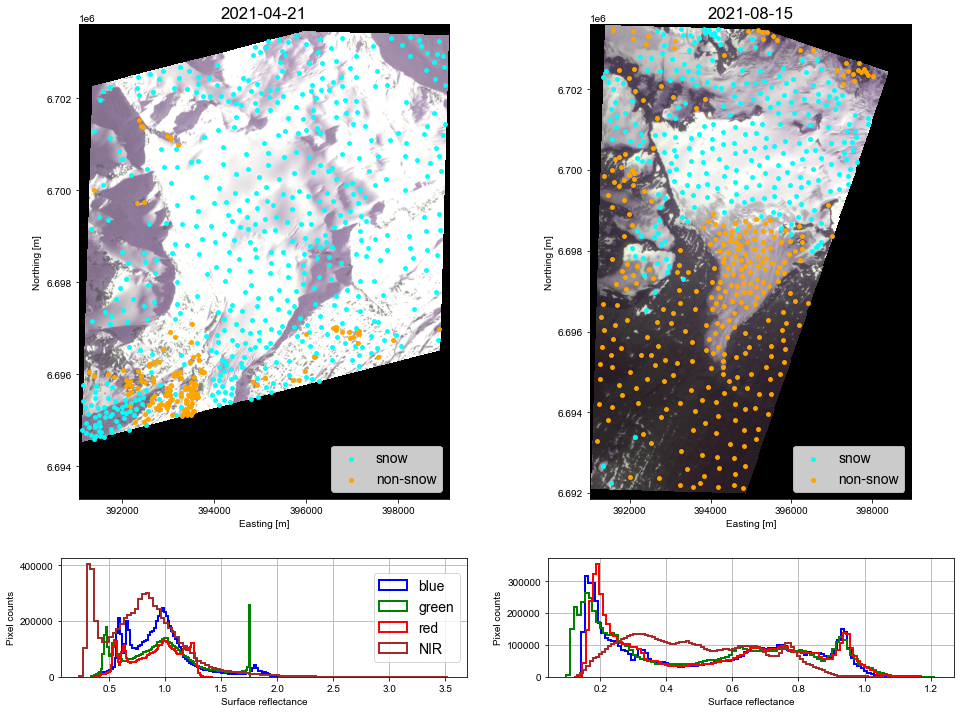

figure saved to file


In [3]:
# -----Define EPSG code
epsg = 32606

# -----2021-04-21
# load image
im1_fn = im_path+'20210421_165659_0f21_3B_AnalyticMS_SR_clip_PS2_adj.tif'
im1 = rio.open(im1_fn)
# read bands
im_scalar = 10000
b1 = im1.read(1).astype(float) #/ im_scalar
r1 = im1.read(2).astype(float) #/ im_scalar
g1 = im1.read(3).astype(float) #/ im_scalar
nir1 = im1.read(4).astype(float) #/ im_scalar
# define coordinates grid
im1_x = np.linspace(im1.bounds.left, im1.bounds.right, num=np.shape(b1)[1])
im1_y = np.linspace(im1.bounds.top, im1.bounds.bottom, num=np.shape(b1)[0])
print('Image 1 CRS:',im1.crs)
# load snow training points
data_snow_pts1_fn = base_path+'../study-sites/Wolverine/classified-points/snow_points_20210421.shp'
data_snow_pts1 = gpd.read_file(data_snow_pts1_fn)
# reproject to defined CRS
data_snow_pts1 = data_snow_pts1.to_crs(epsg)
print('Snow points 1 CRS:', data_snow_pts1.crs)
# load non-snow points
data_non_snow_pts1_fn = base_path+'../study-sites/Wolverine/classified-points/non_snow_points_20210421.shp'
data_non_snow_pts1 = gpd.read_file(data_non_snow_pts1_fn)
# Reproject to defined CRS
data_non_snow_pts1 = data_non_snow_pts1.to_crs(epsg)
print('Non-snow points 1 CRS:', data_non_snow_pts1.crs)

# -----2021-08-15
im2_fn = im_path+'20210815_202055_60_2459_3B_AnalyticMS_SR_clip_PSB.SD_adj.tif'
im2 = rio.open(im2_fn)
# read bands
b2 = im2.read(1).astype(float) #/ im_scalar
r2 = im2.read(2).astype(float) #/ im_scalar
g2 = im2.read(3).astype(float) #/ im_scalar
nir2 = im2.read(4).astype(float) #/ im_scalar
# define coordinates grid
im2_x = np.linspace(im2.bounds.left, im2.bounds.right, num=np.shape(b2)[1])
im2_y = np.linspace(im2.bounds.top, im2.bounds.bottom, num=np.shape(b2)[0])
print('Image 2 CRS:',im2.crs)
# load snow training points
data_snow_pts2_fn = base_path+'../study-sites/Wolverine/classified-points/snow_points_20210815.shp'
data_snow_pts2 = gpd.read_file(data_snow_pts2_fn)
# reproject to defined CRS
data_snow_pts2 = data_snow_pts2.to_crs(epsg)
print('Snow points 2 CRS:', data_snow_pts2.crs)
# load non-snow points
data_non_snow_pts2_fn = base_path+'../study-sites/Wolverine/classified-points/non_snow_points_20210815.shp'
data_non_snow_pts2 = gpd.read_file(data_non_snow_pts2_fn)
# Reproject to defined CRS
data_non_snow_pts2 = data_non_snow_pts2.to_crs(epsg)
print('Non-snow points 2 CRS:', data_non_snow_pts2.crs)

# -----Plot RGB images, data point locations, and band histograms
fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,12), gridspec_kw={'height_ratios': [4,1]})
plt.rcParams.update({'font.size': 14, 'font.sans-serif': 'Arial'})
# 2021-04-21
ax1.imshow(np.dstack([r1, g1, b1]), 
           extent=(np.min(im1_x), np.max(im1_x), np.min(im1_y), np.max(im1_y)))
data_snow_pts1.plot(ax=ax1, markersize=15, color='cyan', label='snow')
data_non_snow_pts1.plot(ax=ax1, markersize=15, color='orange', label='non-snow')
ax1.legend(loc='lower right')
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
ax1.set_title('2021-04-21')
ax3.hist(b1[b1>0].flatten(), color='blue', histtype='step', linewidth=2, bins=100, label='blue')
ax3.hist(g1[g1>0].flatten(), color='green', histtype='step', linewidth=2, bins=100, label='green')
ax3.hist(r1[r1>0].flatten(), color='red', histtype='step', linewidth=2, bins=100, label='red')
ax3.hist(nir1[nir1>0].flatten(), color='brown', histtype='step', linewidth=2, bins=100, label='NIR')
ax3.set_xlabel('Surface reflectance')
ax3.set_ylabel('Pixel counts')
# ax3.set_ylim(0,np.max([h_nir[0][1:], h_g[0][1:], h_r[0][1:], h_b[0][1:]])+5000)
ax3.grid()
ax3.legend(loc='right')
# 2021-08-15
ax2.imshow(np.dstack([r2, g2, b2]), 
           extent=(np.min(im2_x), np.max(im2_x), np.min(im2_y), np.max(im2_y)))
data_snow_pts2.plot(ax=ax2, markersize=15, color='cyan', label='snow')
data_non_snow_pts2.plot(ax=ax2, markersize=15, color='orange', label='non-snow')
ax2.legend(loc='lower right')
ax2.set_xlabel('Easting [m]')
ax2.set_ylabel('Northing [m]')
ax2.set_title('2021-08-15')
ax4.hist(b2[b2>0].flatten(), color='blue', histtype='step', linewidth=2, bins=100, label='blue')
ax4.hist(g2[g2>0].flatten(), color='green', histtype='step', linewidth=2, bins=100, label='green')
ax4.hist(r2[r2>0].flatten(), color='red', histtype='step', linewidth=2, bins=100, label='red')
ax4.hist(nir2[nir2>0].flatten(), color='brown', histtype='step', linewidth=2, bins=100, label='NIR')
ax4.set_xlabel('Surface reflectance')
ax4.set_ylabel('Pixel counts')
# ax4.set_ylim(0,np.max([h_nir[0][1:], h_g[0][1:], h_r[0][1:], h_b[0][1:]])+5000)
ax4.grid()
plt.show()

# -----Save figure
if save_outputs==True:
    fig.savefig(figures_out_path+'training_data.png', dpi=200, facecolor='white', edgecolor='none')
    print('figure saved to file')

### Set up training data
Add 'snow' classification column, merge snow and non-snow points, sample band values at points, and add NDSI column

In [4]:
# -----Add date and snow classification column to data points
data_snow_pts1['date'] = '2021-04-21'
data_snow_pts1['snow'] = 1
data_non_snow_pts1['date'] = '2021-04-21'
data_non_snow_pts1['snow'] = 0
data_snow_pts2['date'] = '2021-08-15'
data_snow_pts2['snow'] = 1
data_non_snow_pts2['date'] = '2021-08-15'
data_non_snow_pts2['snow'] = 0

# -----Merge snow and non-snow points
data_pts = data_snow_pts1.append(data_snow_pts2, ignore_index=True).append(data_non_snow_pts1, ignore_index=True).append(data_snow_pts2, ignore_index=True)
# Add coords column
data_pts['coords'] = [(pt.bounds[0], pt.bounds[1]) for pt in data_pts['geometry']]
# remove "id" and "geometry" columns
data_pts = data_pts.drop(columns=['id', 'geometry'])

# -----Sample band values at points
data_pts['blue'] = ' '
data_pts['green'] = ' '
data_pts['red'] = ' '
data_pts['NIR'] = ' '
data_pts['blue'].loc[data_pts['date']=='2021-04-21'] = [x[0] for x in im1.sample(data_pts['coords'].loc[data_pts['date']=='2021-04-21'])]
data_pts['blue'].loc[data_pts['date']=='2021-08-15'] = [x[0] for x in im2.sample(data_pts['coords'].loc[data_pts['date']=='2021-08-15'])]
data_pts['green'].loc[data_pts['date']=='2021-04-21'] = [x[1] for x in im1.sample(data_pts['coords'].loc[data_pts['date']=='2021-04-21'])]
data_pts['green'].loc[data_pts['date']=='2021-08-15'] = [x[1] for x in im2.sample(data_pts['coords'].loc[data_pts['date']=='2021-08-15'])]
data_pts['red'].loc[data_pts['date']=='2021-04-21'] = [x[2] for x in im1.sample(data_pts['coords'].loc[data_pts['date']=='2021-04-21'])]
data_pts['red'].loc[data_pts['date']=='2021-08-15'] = [x[2] for x in im2.sample(data_pts['coords'].loc[data_pts['date']=='2021-08-15'])]
data_pts['NIR'].loc[data_pts['date']=='2021-04-21'] = [x[3] for x in im1.sample(data_pts['coords'].loc[data_pts['date']=='2021-04-21'])]
data_pts['NIR'].loc[data_pts['date']=='2021-08-15'] = [x[3] for x in im2.sample(data_pts['coords'].loc[data_pts['date']=='2021-08-15'])]

# -----Add NDSI column
data_pts['NDSI'] = (data_pts['red'] - data_pts['NIR']) / (data_pts['red'] + data_pts['NIR'])

print(data_pts)

/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


            date  snow                                   coords      blue  \
0     2021-04-21     1   (394187.6795642532, 6700941.935079832)  1.109891   
1     2021-04-21     1   (393653.4003846875, 6700641.987236497)  1.007432   
2     2021-04-21     1  (393494.05381977407, 6700613.866871574)  0.801561   
3     2021-04-21     1   (392837.91995848616, 6700904.43860953)   1.02435   
4     2021-04-21     1  (392903.53419432865, 6700510.758852334)  1.043412   
...          ...   ...                                      ...       ...   
1184  2021-08-15     1  (395093.97376853717, 6703054.181822755)  0.641157   
1185  2021-08-15     1  (394721.67662026634, 6703011.048956646)  0.802459   
1186  2021-08-15     1    (396626.320049147, 6702738.080987816)  0.737743   
1187  2021-08-15     1    (396264.031706056, 6702732.590925822)  0.782611   
1188  2021-08-15     1  (395802.93790838897, 6702529.488803247)  0.753538   

         green       red       NIR      NDSI  
0     1.154676   1.17814   1

### Test supervised classification algorithms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


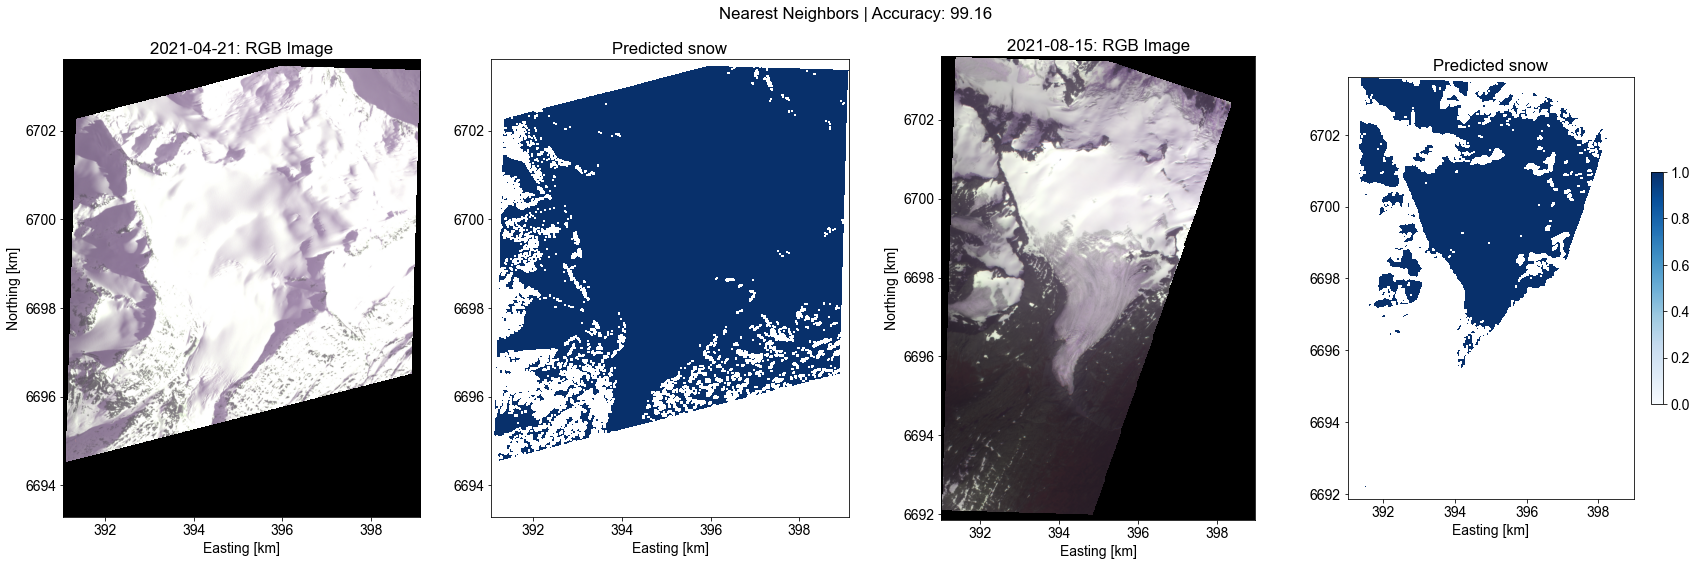

figure saved to file


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


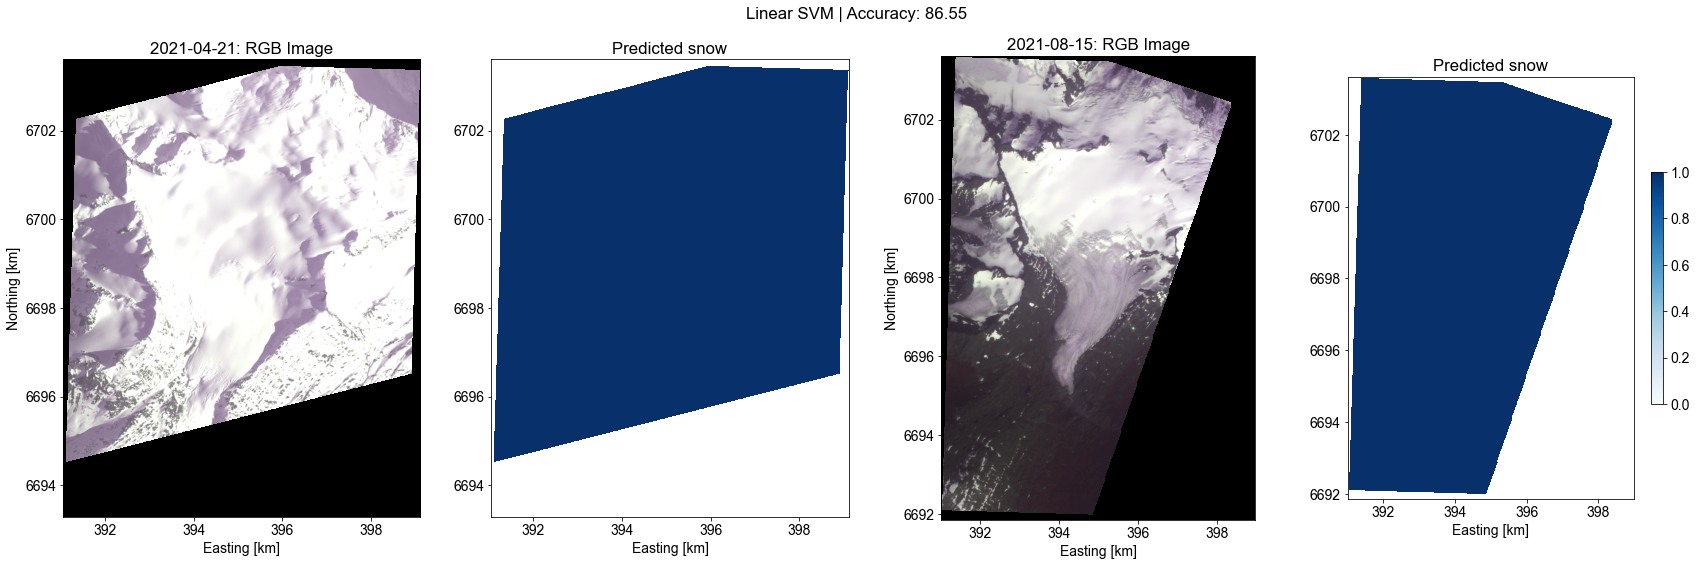

figure saved to file


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


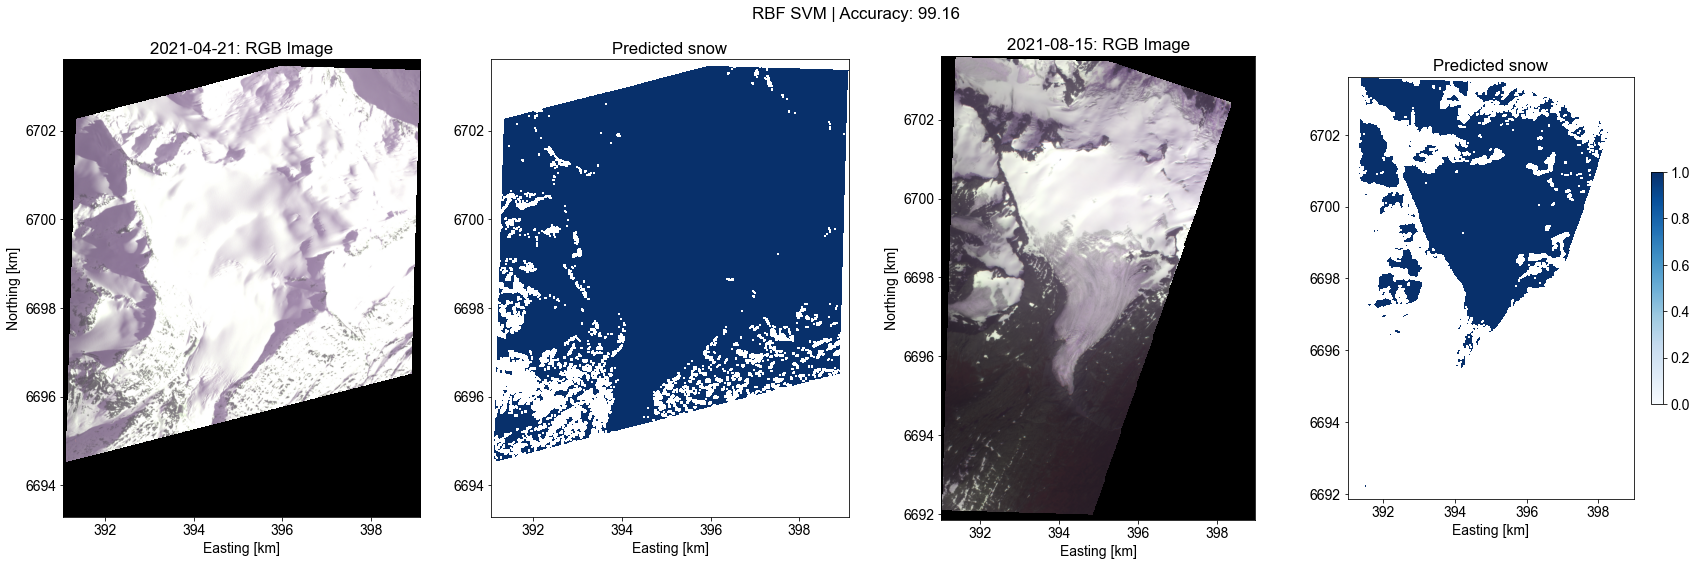

figure saved to file


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


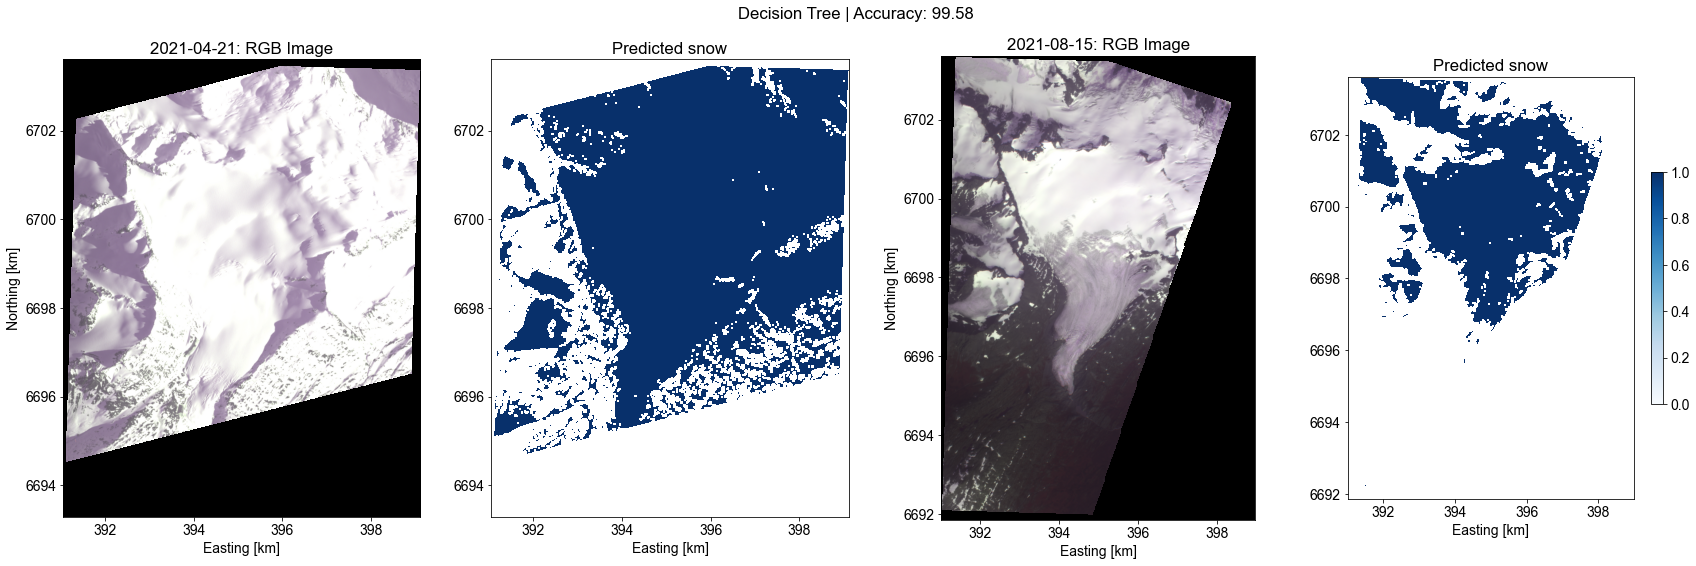

figure saved to file


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


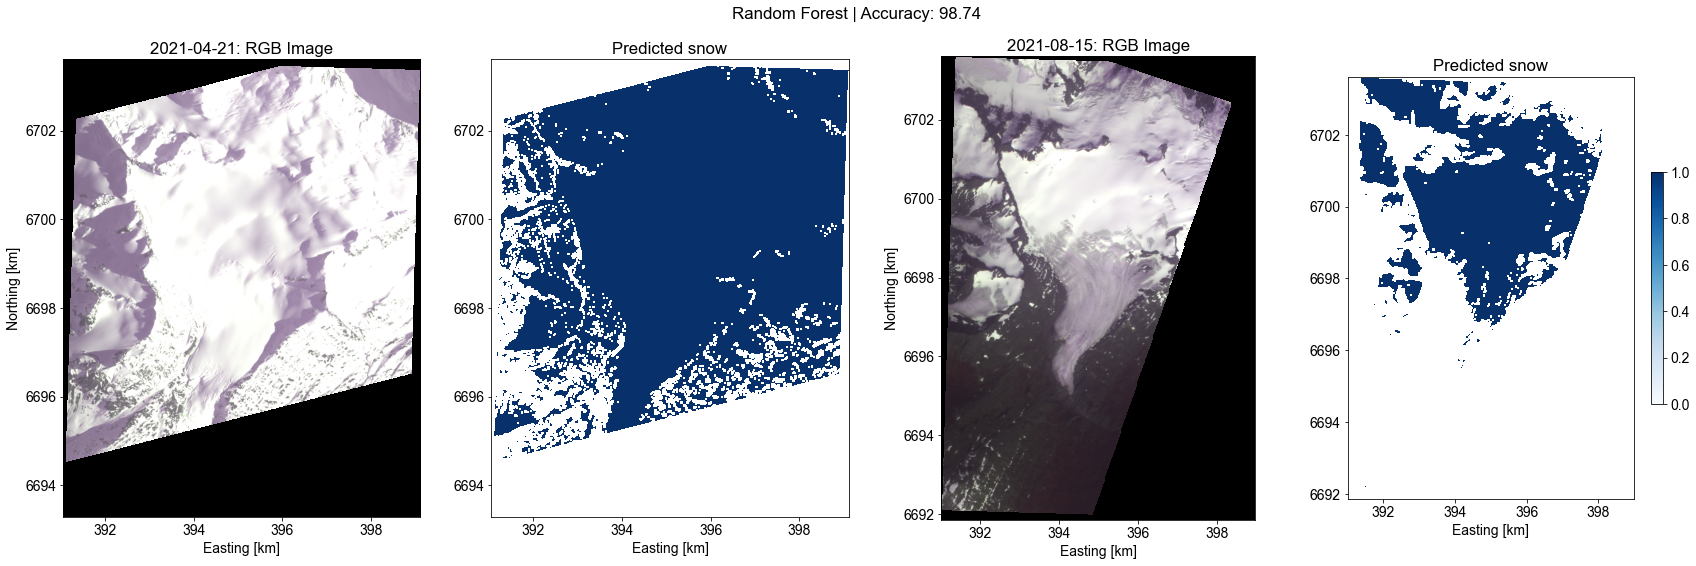

figure saved to file


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


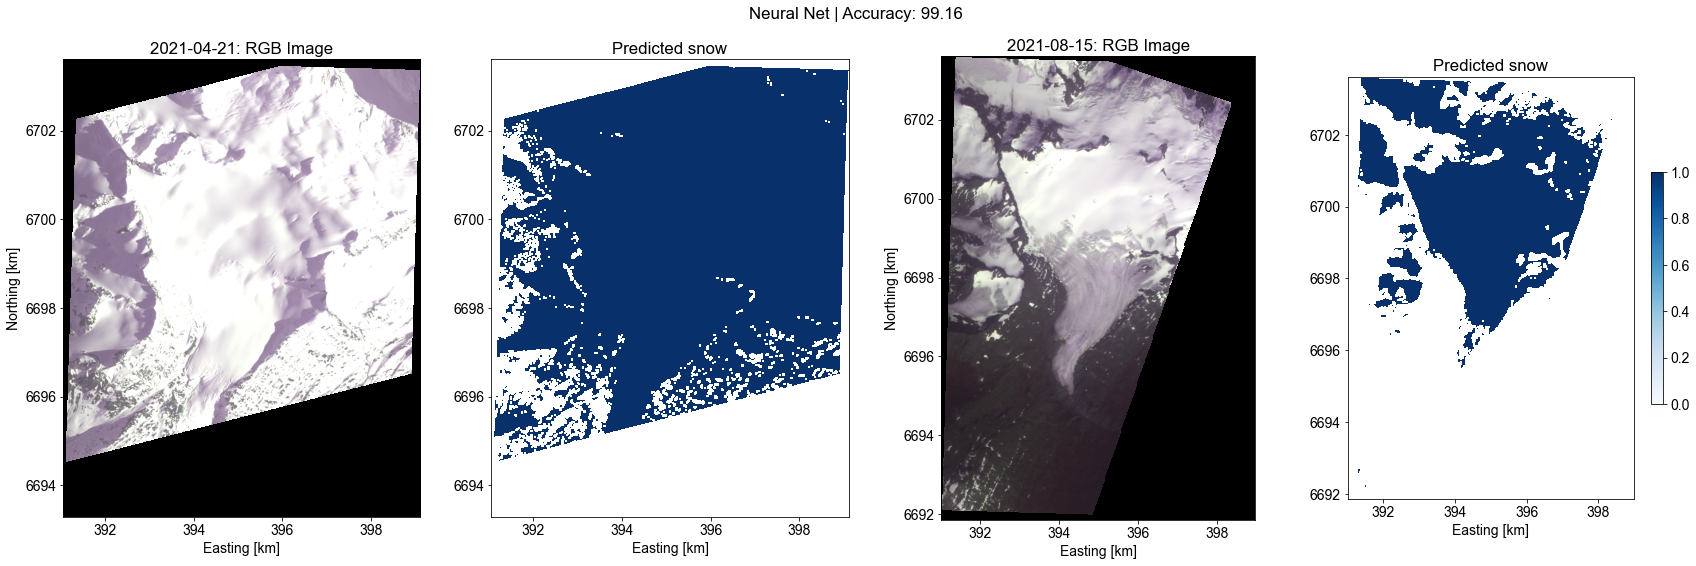

figure saved to file


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


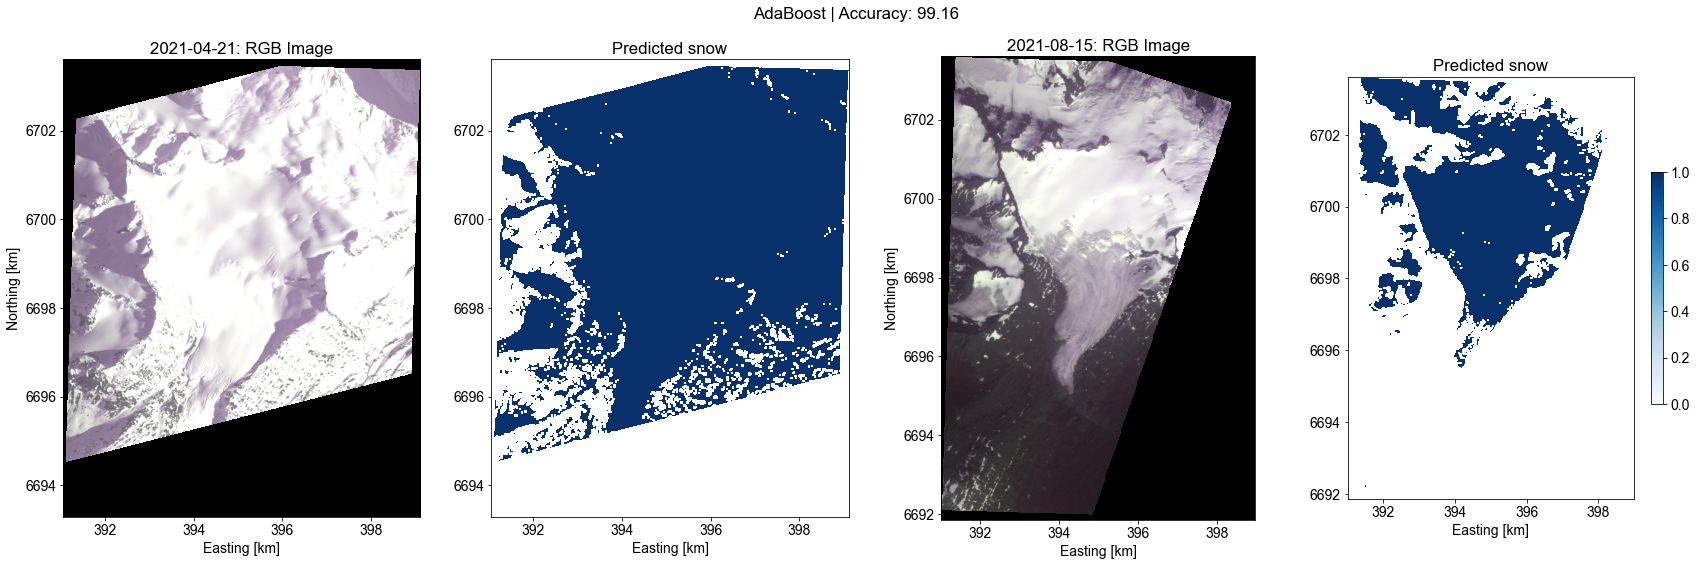

figure saved to file


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


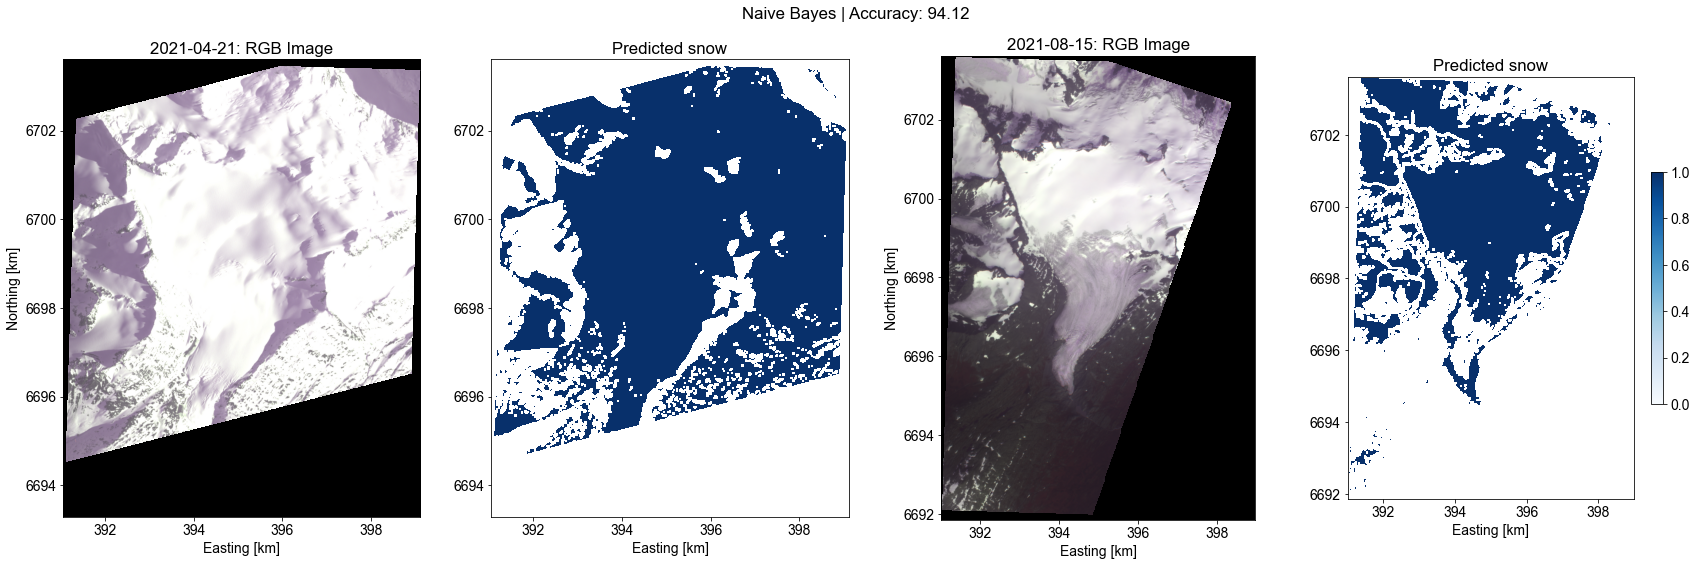

figure saved to file


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


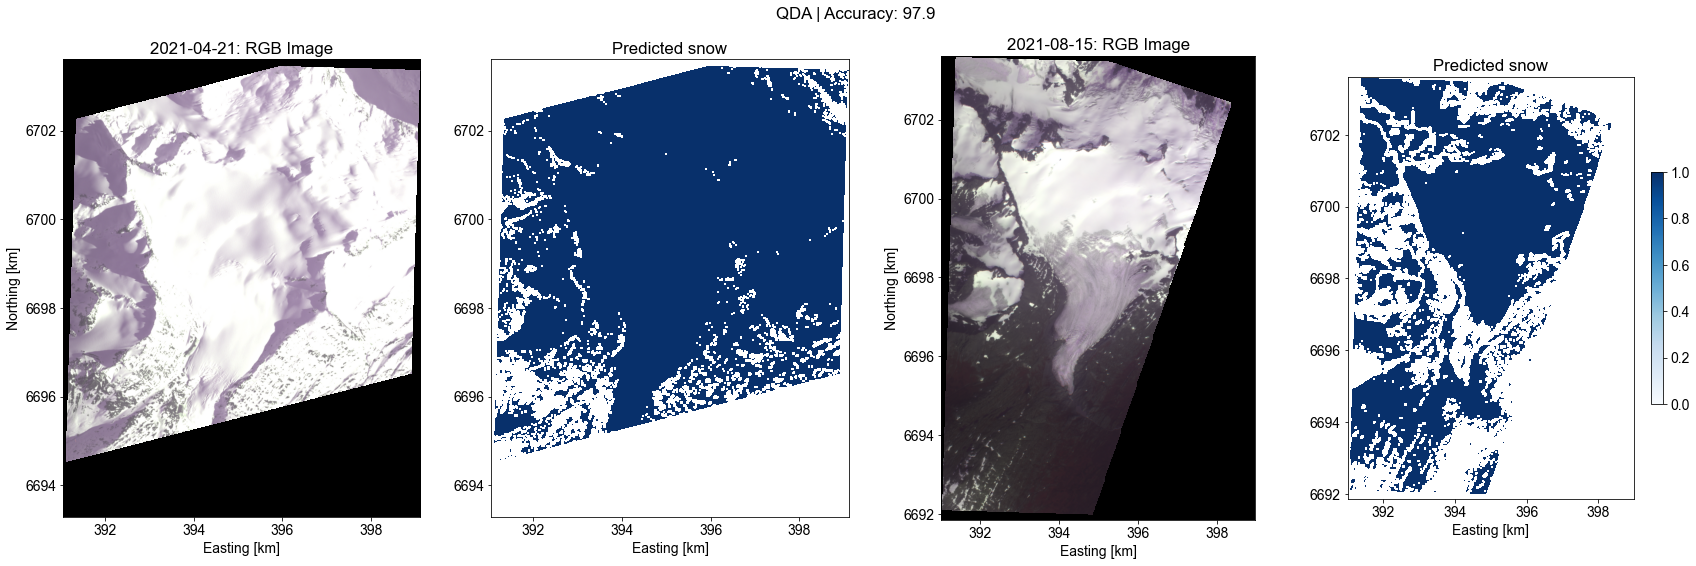

figure saved to file


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


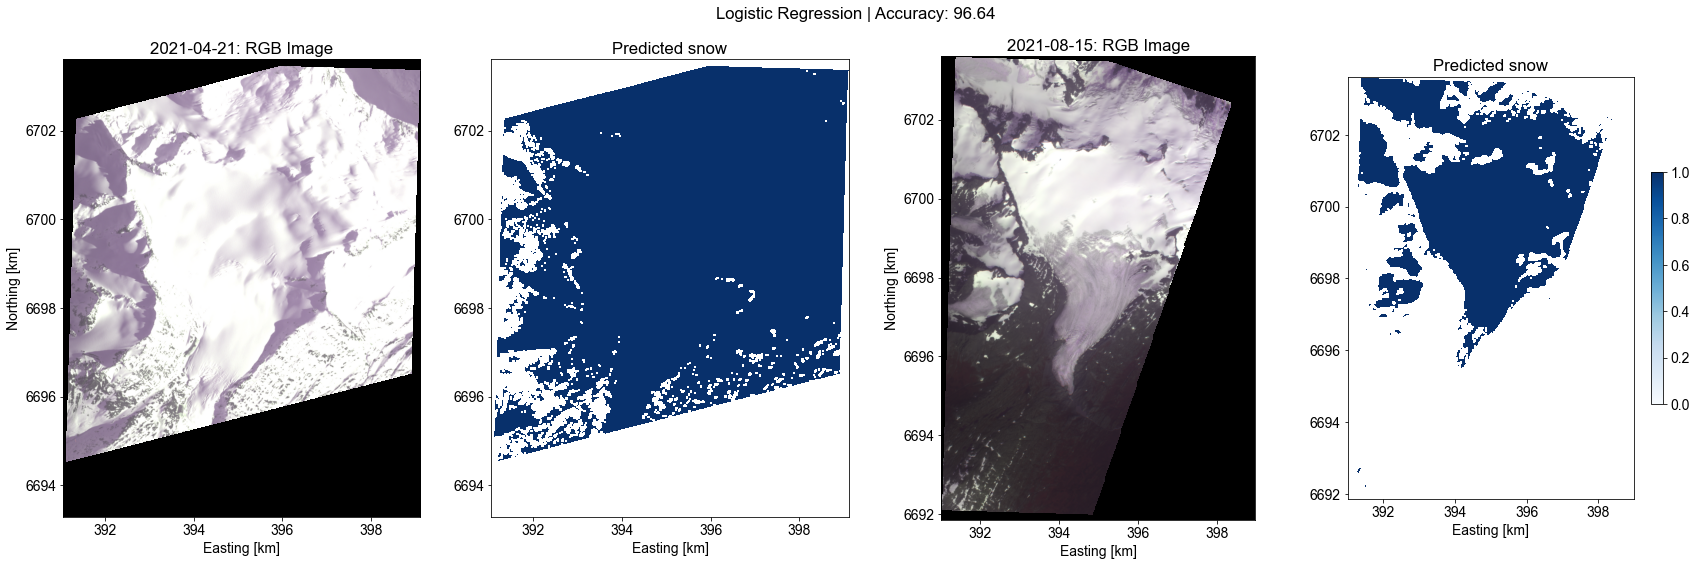

figure saved to file
            Classifier  Accuracy
0    Nearest Neighbors  0.991597
1           Linear SVM  0.865546
2              RBF SVM  0.991597
3        Decision Tree  0.995798
4        Random Forest  0.987395
5           Neural Net  0.991597
6             AdaBoost  0.991597
7          Naive Bayes  0.941176
8                  QDA  0.978992
9  Logistic Regression  0.966387

Best accuracy classifier: Decision Tree

Time elapsed:  9.388580652077993  minutes
Most accurate classifier saved to file:  /Users/raineyaberle/Research/PhD/planet-snow/inputs-outputs/best_classifier.sav


In [5]:
# -----Start timer
t1 = time.time() 

# -----Split data points into features (band values) and target variable (snow)
feature_cols = ['red', 'NIR', 'NDSI'] #['blue', 'green', 'red', 'NIR', 'NDSI']
X = data_pts[feature_cols] # features
y = data_pts['snow'] # target variable

# -----Split data points into testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----Classifier names
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
#     "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "Logistic Regression"
]

# -----Classifiers
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(random_state = 0)
]
    
# -----Iterate over classifiers
i = 0 # loop counter
accuracy = [] # classifier accuracy
for name, clf in zip(names, classifiers):
    
    # train classifier
    clf.fit(X_train, y_train)
    
    # calculate accuracy
    y_pred = clf.predict(X_test)
    accuracy = accuracy + [metrics.accuracy_score(y_test, y_pred)]
    
    # predict snow classification for the full image 
    snow1 = classify_image(im1, clf, False)[2]
    snow2 = classify_image(im2, clf, False)[2]

    # plot results
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 8))
    plt.rcParams.update({'font.size': 14, 'font.sans-serif': 'Arial'})
    # 2021-04-21
    ax1.imshow(np.dstack([r1, g1, b1]), 
               extent=(np.min(im1_x)/1000, np.max(im1_x)/1000, np.min(im1_y)/1000, np.max(im1_y)/1000))
    ax1.set_title('2021-04-21: RGB Image')
    ax1.set_ylabel('Northing [km]')
    ax1.set_xlabel('Easting [km]')
    snow1_plot = ax2.imshow(np.where(snow1==1, snow1, np.nan), cmap='Blues', clim=(0,1),
                            extent=(np.min(im1_x)/1000, np.max(im1_x)/1000, np.min(im1_y)/1000, np.max(im1_y)/1000))
    ax2.set_title('Predicted snow')
    ax2.set_xlabel('Easting [km]')
    # 2021-08-15
    ax3.imshow(np.dstack([r2, g2, b2]), 
               extent=(np.min(im2_x)/1000, np.max(im2_x)/1000, np.min(im2_y)/1000, np.max(im2_y)/1000))
    ax3.set_title('2021-08-15: RGB Image')
    ax3.set_ylabel('Northing [km]')
    ax3.set_xlabel('Easting [km]')
    snow2_plot = ax4.imshow(np.where(snow2==1, snow2, np.nan), cmap='Blues', clim=(0,1),
                            extent=(np.min(im2_x)/1000, np.max(im2_x)/1000, np.min(im2_y)/1000, np.max(im2_y)/1000))
    ax4.set_title('Predicted snow')
    ax4.set_xlabel('Easting [km]')
    fig.suptitle(name + ' | Accuracy: ' + str(np.round(accuracy[i]*100,2)))
    fig.colorbar(snow2_plot, ax=ax4, shrink=0.5)
    plt.tight_layout()
    plt.show()
    
    # -----Save figure
    if save_outputs:
        fig.savefig(figures_out_path + name.replace(' ','') + '_results.png', 
                    dpi=200, facecolor='white', edgecolor='none')
        print('figure saved to file')
    
    i+=1

# -----Determine best classifier based on accuracy
results = pd.DataFrame()
results['Classifier'], results['Accuracy'] = names, accuracy
clf_best_name = names[np.where(accuracy==np.max(accuracy))[0][0]]
clf_best = classifiers[np.where(accuracy==np.max(accuracy))[0][0]]
print(results)
print('')
print('Best accuracy classifier: ' + clf_best_name)

# -----Display time elapsed
t2 = time.time() # stop timer
print('')
print('Time elapsed: ',str((t2-t1)/60),' minutes')

# -----Save most accurate classifier
if save_outputs==True:
    clf_fn = out_path+'best_classifier.sav'
    pickle.dump(clf_best, open(clf_fn, 'wb'))
    print('Most accurate classifier saved to file: ',clf_fn)